<img src = './logo.png'>

* ref: https://dacon.io/competitions/official/235680/overview/description

# Competetion Description

##. 평가
KOSPI-200과 KOSDAQ-150의 주어진 기간 중 마지막으로 거래된 가격(종가) 예측

평가 산식: NMAE * 100

평가 (Public, Private score)
public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
private score: 11월 29일 ~ 12월 3일 주식 종료 예측값


## Feature
1.stock_list.csv : 종목 번호 데이터

종목명 : 주식 종목 명
종목코드 : 주식 종목 코드번호
상장시장 : 주식 종목 상장 시장 (KOSPI or KOSDAQ)
 

2.sample_submission.csv

sample_submission 데이터

sample_submission.shape : (10, 371)

# 0. Pre-Setting

## 0.1 Import

In [ ]:
# 
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# warning
import warnings
warnings.filterwarnings(action='ignore')

# re
import re

# os
import os
import shutil # shutil.rmtree

# datetime
import datetime as dt 
from dateutil.rrule import rrule, YEARLY, MONTHLY, WEEKLY

# visualization
import matplotlib.pyplot as plt
plt.rc('font', family='Gothic') # For Windows. PLOT에서 한글 처리 -> 플롯 만드는 창에 넣어야 됨.

plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # - 기호 안 깨지게
plt.rcParams['font.size'] = 15

from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

%matplotlib inline 

# plt.figure(figsize=(12,4)) # plot 12:4 비율

import seaborn as sns
sns.set() # seaborn에서 회색 grid 깔아줌
sns.set(rc={'figure.figsize':(18, 5)}) # 결과 plot 크기 키워줌


In [ ]:
# 사이킷런
from sklearn.model_selection import train_test_split

# 사이킷런 분류
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC

# 사이킷런 분류 점수
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# 						 # ---> y_true, y_pred
# from sklearn.metrics import precision_recall_curve # y_true, probas_pred
# from sklearn.metrics import roc_auc_score, roc_curve # y_true, y_score

# 분류 ensemble
# import xgboost as xgb
# from xgboost import plot_importance 
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier # lgb.쓰기 귀찮으니까 Classifier까지 import
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
# sklearn regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.svm import SVC #linear SVC는 classifier 성 / SVC는 분류말고 회귀에도 쓸 수 있다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score # squared=False로 하면 RMSE

In [ ]:
# sklearn scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# sklearn augmentation
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

In [ ]:
# ------------- tensorflow & keras -----------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
from keras.layers import LSTM                              #-------------RNN
from keras.preprocessing.image import ImageDataGenerator   #-------------Augmentation
from keras.preprocessing.image import array_to_img, img_to_array, load_img # ㄴ flow



from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

# --------------------- etc. -----------------------
from PIL import Image

# ----------------- fixing seed --------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [ ]:
! pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 0.2 Classes, Methods

In [ ]:
MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"

def target_split(df, shift_size = 1, target = 'Close'):
    X = df.drop(target, axis=1)
    y = df[target]
    y = y.shift(shift_size)
    return X.iloc[shift_size:,:], y.iloc[shift_size:]

def test_split(X, y, window_size = 20):

    test1_from = y.index[(np.where(y.index=='2021-11-01')[0][0] - window_size)]
    test2_from = y.index[(np.where(y.index=='2021-11-26')[0][0] - window_size)]

    X_train = X.loc[:'2021-10-29', :]
    y_train = y[:'2021-10-29']

    X_test1 = X.loc[test1_from:'2021-11-05', :] # 2021-11-02 ~ 2021-11-05 (전 날 기준, y축이 하루 밀려있기 때문)
    y_test1 = y[test1_from:'2021-11-05']

    X_test2 = X.loc[test2_from:'2021-12-02', :] # 2021-11-29 ~ 2021-12-03 (전 날 기준, y축이 하루 밀려있기 때문)
    y_test2 = y[test2_from:'2021-12-02']

    return X_train, y_train, X_test1, y_test1, X_test2, y_test2

def val_split(X_train, y_train, split_ratio=0.2):
    if X_train.shape[0]!=y_train.shape[0]:
        print('*********error!!!*********')

    else:
        val_size = int(X_train.shape[0]*split_ratio)
        
        X_val = X_train[-val_size:]
        X_train = X_train[:-val_size]

        y_val = y_train[-val_size:]
        y_train = y_train[:-val_size]

        # print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

        return X_train, X_val, y_train, y_val

class my_train():
    def __init__(self, X, y):
        self.X = X
        self.y = y

        self.X_window = None
        self.y_window = None

        self.model = None
        self.res = None # res.history = {'loss': , 'val_loss'}

    def window_data(self, window_size = 20):
        

        X_list = []
        y_list = []

        for i in range(len(self.X) - window_size):
            X_list.append(self.X.iloc[i : i+window_size, :])
            y_list.append(self.y.iloc[i+window_size])
            
        self.X_window = np.array(X_list)
        self.y_window = np.array(y_list)

        # print(self.X_window.shape, self.y_window.shape)
        return self.X_window, self.y_window


    def my_fit(self, hidden_layer=None, return_sequences = False, units__=16, epochs__ = 100, model_path = MODELPAHT__, model_save = False):
        # model layer
        if hidden_layer == None:
            hidden_layer = []
        else:
            hidden_layer = hidden_layer
        
        input_layer = LSTM(units = units__,
                            input_shape = (self.X_window.shape[1:]),
                            activation = 'tanh',
                            recurrent_activation = 'sigmoid',
                            dropout=0.0,
                            recurrent_dropout = 0.0,
                            return_sequences = return_sequences) # True(many to many), False(many to one)
        
        output_layer = Dense(units = 1)

        hidden_layer.insert(0, input_layer) 
        hidden_layer.append(output_layer)

        
        self.model = Sequential(hidden_layer)
        print(self.model.summary())

        # compile
        self.model.compile(loss="mae", optimizer='adam')# , metrics="mae")

        # callback
        callback_list = []
        if model_save == True:
            if os.path.exists(model_path):
                shutil.rmtree(model_path) 

            if not os.path.exists(model_path):
                os.mkdir(model_path)  

            check_point = ModelCheckpoint(filepath=model_path+'/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=False
                       )
            callback_list.append(check_point)

        stop = EarlyStopping(patience=10, monitor='val_loss')
        callback_list.append(stop)

        # fit
        self.res = self.model.fit(self.X_window, self.y_window, 
                            callbacks=callback_list,
                            epochs = epochs__,
                            batch_size = 32,
                            validation_split=0.2
                            )
        
        # plot
        plt.plot(np.arange(len(self.res.history['loss'])), self.res.history['loss'], c='red', label='train_loss')
        plt.plot(np.arange(len(self.res.history['val_loss'])), self.res.history['val_loss'], c='blue', label='val_loss')
        plt.legend()
        plt.show()


    def my_predict(self, X_test, y_test = None, y_scaler = None, plot = False, window_size=20):

        # window data
        X_list = []
        y_list = []
        window_size = window_size

        for i in range(len(X_test) - window_size):
            X_list.append(X_test.iloc[i : i+window_size, :])
            if str(y_test) != 'None':
                y_list.append(y_test.iloc[i+window_size])
            
        X_test_window = np.array(X_list)
        y_test_window = np.array(y_list)
        print(X_test_window.shape, y_test_window.shape)
        # predict
        pred = self.model.predict(X_test_window)
        # print('predict.shape: ',pred.shape)
        
        if y_scaler != None:
            pred = y_scaler.inverse_transform(pred)

            if str(y_test) != 'None':
                y_test = y_scaler.inverse_transform(y_test_window)

        # score
        print('**'*30)
        print("NMAE: ", np.sum(abs(pred-y_test))*pred.shape[0]/np.mean(y_test))
        print('**'*30)

        # plot
        if plot == True:
            plt.plot(self.X.index[-X_test_window.shape[0]:], pred, c='red', label='pred')
            
            if str(y_test) != 'None':
                plt.plot(self.X.index[-X_test_window.shape[0]:], y_test, c='blue', label='ytest')
            
            plt.legend()
            plt.show()

        return pred



In [ ]:
# def target_split(df, shift_size = 1, target = 'Close'):
#     X = df.drop(target, axis=1)
#     y = df[target]
#     y = y.shift(shift_size)
#     return X.iloc[shift_size:,:], y.iloc[shift_size:]

In [ ]:
# def window_data(X, y, window_size = 20):
#     X = X.fillna(method = 'bfill')

#     X_list = []
#     y_list = []

#     for i in range(len(X) - window_size):
#         X_train=X.iloc[i : i+window_size, :]
#         y_train=y.iloc[i+window_size]
#         X_list.append(X_train)
#         y_list.append(y_train)

#     return np.array(X_list), np.array(y_list)

In [ ]:
# def val_split(X_train, y_train, split_ratio=0.2):
#     if X_train.shape[0]!=y_train.shape[0]:
#         print('*********error!!!*********')

#     else:
#         val_size = int(X_train.shape[0]*split_ratio)
        
#         X_val = X_train[-val_size:]
#         X_train = X_train[:-val_size]

#         y_val = y_train[-val_size:]
#         y_train = y_train[:-val_size]

#         print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

#         return X_train, X_val, y_train, y_val


# 1. Data Load

## 1.1 load

In [ ]:
# colab
# load train & submission data
stock_list = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/stock_list.csv')
sub = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/sample_submission (1).csv')

In [ ]:
com_df = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/com_df.csv')

## 1.2 shape

In [ ]:
stock_list.shape, sub.shape

((370, 3), (10, 371))

## 1.3 info

In [ ]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     370 non-null    object
 1   종목코드    370 non-null    int64 
 2   상장시장    370 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 371 entries, Day to 950130
dtypes: int64(370), object(1)
memory usage: 29.1+ KB


## 1.4 head

In [ ]:
stock_list.head(3)

,종목명,종목코드,상장시장
0,삼성전자,5930,KOSPI
1,SK하이닉스,660,KOSPI
2,NAVER,35420,KOSPI


In [ ]:
sub.head(3)

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.5 pre-processing

### 1.5.1 merge stock_list DataFrame & listed company info DataFrame

In [ ]:
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
com_df['stock_code']=com_df['stock_code'].apply(lambda x :  str(x).zfill(6))
com_df['stock_code_ori']=com_df['stock_code_ori'].apply(lambda x :  str(x).zfill(6))

In [ ]:
condition = com_df[(com_df.duplicated(subset='stock_code_ori', keep='first')) & (com_df['stock_code']==com_df['stock_code_ori'])]
com_df=com_df.drop(condition.index, axis=0)

In [ ]:
stock_list = pd.merge(stock_list, com_df, left_on='종목코드', right_on='stock_code', how='left')

In [ ]:
stock_list=stock_list.drop(['cd', 'nm', 'corp_name', 'stock_code', '표준코드', '단축코드', '한글 종목명', '한글 종목약명', '영문 종목명', 'yh_code', 'stock_code_ori'], axis=1)

In [ ]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   종목명           370 non-null    object 
 1   종목코드          370 non-null    object 
 2   상장시장          370 non-null    object 
 3   industry      357 non-null    object 
 4   main_product  356 non-null    object 
 5   listed_date   357 non-null    object 
 6   settle_month  357 non-null    object 
 7   hpage         348 non-null    object 
 8   상장일           357 non-null    object 
 9   증권구분          357 non-null    object 
 10  주식종류          357 non-null    object 
 11  액면가           357 non-null    object 
 12  상장주식수         357 non-null    float64
dtypes: float64(1), object(12)
memory usage: 40.5+ KB


In [ ]:
del(com_df)

In [ ]:
stock_list[stock_list['industry'].isna()]

,종목명,종목코드,상장시장,industry,main_product,listed_date,settle_month,hpage,상장일,증권구분,주식종류,액면가,상장주식수
68,KODEX 200,069500,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,KODEX 단기채권,153130,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,KODEX 200선물인버스2X,252670,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,TIGER 200,102110,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,KODEX 삼성그룹,102780,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,롯데리츠,330590,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,KODEX 단기채권PLUS,214980,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,KODEX 레버리지,122630,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,KODEX 종합채권(AA-이상)액티브,273130,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,KODEX 200TR,278530,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.6 load other data

### 1.6.1 VIX 

In [ ]:
# vix = fdr.DataReader('VIX', '2000-01-06', '2021-03-09') # S&P 500 VIX

In [ ]:
# vix.info()

In [ ]:
# plt.plot(vix['Close'], label='Close')
# plt.plot(vix['Change']*100, label='Change*100')
# plt.legend()
# plt.show()

### 1.6.2 Stock price

# 2. Predicting Sample stock price

## 2.1 Picking Sample

In [ ]:
sample_p = '006400'
sample_q = '035760'

In [ ]:
stock_list[(stock_list['종목코드']==sample_p) | (stock_list['종목코드']==sample_q)]

In [ ]:
start_date = '19900101'
end_date = '20211215'

name_list = ['p', 'q']
i=0

for code in (sample_p, sample_q): 
    globals()[f'stock_{name_list[i]}'] = fdr.DataReader(code, start = start_date, end = end_date)
    i+=1

In [ ]:
stock_q.info()

In [ ]:
stock_p.info()

In [ ]:
stock_p.plot()

In [ ]:
stock_q.plot()

## 2.2 Pre-processing & engineering

In [ ]:
X_p, y_p = target_split(stock_p, shift_size = 1)
X_q, y_q = target_split(stock_q, shift_size = 1)

In [ ]:
X_p.info(), X_q.info()

In [ ]:
y_p.isna().sum(), y_q.isna().sum()

In [ ]:
temp_list = ['p', 'q']

for idx in temp_list:
    globals()[f'mme_{idx}1'] = MinMaxScaler() # ex. mme_p1 = MinMaxScaler()
    globals()[f'mme_{idx}2'] = MinMaxScaler() # ex. mme_p2 = MinMaxScaler()

    temp = globals()[f'X_{idx}']
    globals()[f'X_{idx}2'] = globals()[f'mme_{idx}1'].fit_transform(temp) # ex. X_p = mme_p1(X_p)

    temp = globals()[f'y_{idx}'].values.reshape(-1,1)
    globals()[f'y_{idx}2'] = globals()[f'mme_{idx}2'].fit_transform(temp) # ex. y_p = mme_p2(y_p.values.reshape(-1,1))

In [ ]:
X_p = pd.DataFrame(X_p2, columns = X_p.columns, index = X_p.index)
y_p = pd.DataFrame(y_p2, columns = [y_p.name], index = y_p.index)
X_q = pd.DataFrame(X_q2, columns = X_q.columns, index = X_q.index)
y_q = pd.DataFrame(y_q2, columns = [y_q.name], index = y_q.index)

# 3. First_trial

In [ ]:
X_p_train, y_p_train = window_data(X_p, y_p, window_size = 20)
print(X_p_train.shape, y_p_train.shape)


X_q_train, y_q_train = window_data(X_q, y_q, window_size = 20)
print(X_q_train.shape, y_q_train.shape)

In [ ]:
model.summary()

In [ ]:
X_p_train, X_p_val, y_p_train, y_p_val = val_split(X_p_train, y_p_train)

In [ ]:
# many_to_one

lstm= LSTM(units =16, # 내보내는 개수
               input_shape = (X_p_train.shape[1:]),
                activation = 'tanh',
                recurrent_activation = 'sigmoid',
                dropout=0.0,
                recurrent_dropout = 0.0,
                return_sequences=False) # sequence내뱉는 걸 다음 놈한테 줄 거냐 말 거냐. True(many to many)는 뒷레이어한테도 준다. False면 옆 놈한테만 준다.(many to one)

model = Sequential()

model.add(lstm)
model.add(Dense(1, ))

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mae", optimizer='adam')# , metrics="mae")

stop = EarlyStopping(patience=10, monitor='val_loss')

check_point = ModelCheckpoint(filepath='/content/gdrive/MyDrive/stock_price_d/models/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',          #------------어떤 점수를 기준으로 모니터링할까
                    save_best_only=True,         #------------이전보다 좋아질때만 저장
                    save_weights_only=False      #------------모델+가중치 같이 저장
                   ) 
res = model.fit(X_p_train, y_p_train, 
          callbacks=[stop, check_point],
          epochs = 100,
          batch_size = 32,
          validation_split=0.2
         )

In [ ]:
plt.plot(np.arange(len(res.history['val_loss'])), res.history['loss'], c='red', label='train_loss_9')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss_1')
plt.legend()
plt.show()


In [ ]:
pred = model.predict(X_p_val)
print(pred.shape, y_p_val.shape)

In [ ]:
plt.plot(X_p.index[-X_p_val.shape[0]:], pred, c='red', label='pred')
plt.plot(X_p.index[-X_p_val.shape[0]:], y_p_val, c='blue', label='ytest')
plt.legend()
plt.show()

In [ ]:
pred_orig   = mme_p2.inverse_transform(pred)
y_p_val_orig   = mme_p2.inverse_transform(y_p_val)
print(pred_orig[:5])

In [ ]:
np.sum(abs(pred_orig-y_p_val_orig))*pred_orig.shape[0]/np.sum(y_p_val_orig)

In [ ]:
plt.plot(X_p.index[-X_p_val.shape[0]:], pred_orig, c='red', label='pred')
plt.plot(X_p.index[-X_p_val.shape[0]:], y_p_val_orig, c='blue', label='real')
plt.legend()
plt.show()


# 4. train model with my_train

## 4.1 Sample

In [ ]:
# start_date = '19900101'
# end_date = '20211215'

# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
# WINDOW_SIZE__ = 20
# UNITS__= 16
# EPOCHS__ = 100
# STOCK_CODE = '035760'

# stock_q = fdr.DataReader(code, start = start_date, end = end_date)

# X, y = target_split(stock_q)

# mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
# mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

# X_scaled = mms_X.fit_transform(X)
# y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

# X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
# y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

# X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
# X_train, X_val, y_train, y_val = val_split(X_train, y_train)


# mt = my_train(X_train, y_train)

# mt.window_data()

# mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

# pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
# pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

# pred = np.zeros((10,1))
# pred[:5] = pred1
# pred[5:] = pred2

# sub[STOCK_CODE] = pred


## 4.2 loop

In [ ]:
stock_list = sub.columns
len(stock_list)

371

In [ ]:
sub.columns

Index(['Day', '000060', '000080', '000100', '000120', '000150', '000240',
       '000250', '000270', '000660',
       ...
       '330860', '336260', '336370', '347860', '348150', '348210', '352820',
       '357780', '363280', '950130'],
      dtype='object', length=371)

18

In [ ]:
sub.iloc[:,:18]

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450
0,2021-11-01,27499.035156,34893.800781,56979.546875,142094.500000,104233.742188,16746.798828,39142.589844,85487.304688,103119.914062,684963.1250,51433.328125,231281.437500,33646.871094,55449.085938,17137.777344,-551.611938,26303.562500
1,2021-11-02,27469.808594,35424.644531,56865.089844,145407.343750,104310.523438,16666.839844,39110.351562,84624.898438,106820.296875,694163.8125,52356.773438,234800.062500,32966.613281,55246.058594,17115.216797,-833.661743,26567.025391
2,2021-11-03,28418.986328,35378.078125,58065.742188,147552.328125,107848.734375,17379.091797,39240.460938,85742.078125,107636.015625,699449.3750,52807.988281,235103.531250,33056.410156,56406.625000,17433.804688,-1328.553101,26398.865234
3,2021-11-04,29209.705078,34352.097656,58036.718750,145329.390625,111467.570312,17168.839844,39356.632812,85138.632812,105695.132812,686658.1875,52465.335938,233630.296875,32442.812500,56178.593750,17168.958984,-1142.830933,26232.287109
4,2021-11-05,28752.289062,34087.144531,57852.406250,145031.968750,127269.726562,17820.890625,39712.796875,86915.218750,106666.773438,689109.1875,52682.167969,229263.890625,32746.052734,56557.929688,17015.882812,-1468.455566,26194.781250
5,2021-11-29,30153.535156,31872.417969,56234.503906,131315.859375,124848.867188,15746.277344,37184.230469,82610.445312,118029.039062,644312.6250,49011.976562,211724.546875,32224.455078,67325.953125,15700.931641,-795.163818,25249.052734
6,2021-11-30,30872.041016,30983.132812,56275.292969,129970.531250,121723.812500,15603.977539,37085.066406,80970.179688,115801.429688,643414.6250,47641.882812,206134.718750,31454.353516,67014.703125,15136.842773,-1024.216431,24666.560547
7,2021-12-01,30167.708984,30072.818359,56149.082031,129844.367188,110702.757812,15272.909180,36579.019531,79204.140625,116197.984375,639226.5625,46484.753906,207883.953125,30891.302734,67104.210938,14760.112305,-1508.167725,24178.255859
8,2021-12-02,30425.914062,28965.419922,55341.648438,125535.554688,108876.937500,15351.515625,36250.035156,78392.773438,114548.500000,630294.2500,45193.859375,202183.187500,30059.607422,63210.976562,14194.910156,-1433.204102,23034.417969
9,2021-12-03,30600.642578,29304.775391,55059.507812,126032.687500,111900.273438,15631.319336,36027.675781,81325.914062,116985.390625,627396.2500,46134.917969,203565.718750,31059.250000,63788.179688,15197.557617,-1291.307251,23521.875000


************************************************************
370 remain......
************************************************************
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 16)                1408      
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 16ms/step - loss: 0.0441 - val_loss: 0.0157
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 0.0099 - val_loss: 0.0164
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0085 - val_loss: 0.00

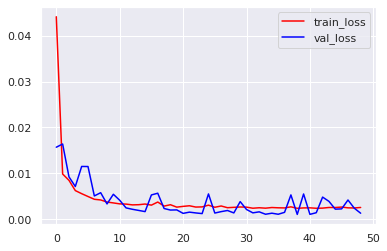

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.10900262218858131
************************************************************


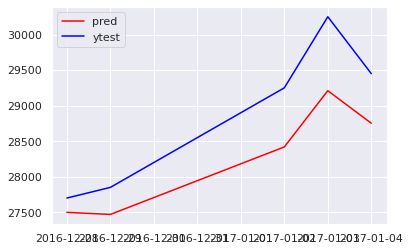

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.15994143730127186
************************************************************


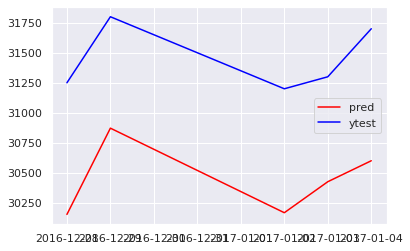

************************************************************
369 remain......
************************************************************
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 16)                1408      
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
59/59 [==============================] - 3s 22ms/step - loss: 0.0546 - val_loss: 0.0206
Epoch 2/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0172 - val_loss: 0.0175
Epoch 3/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0140 - val_loss: 0.0169
Epo

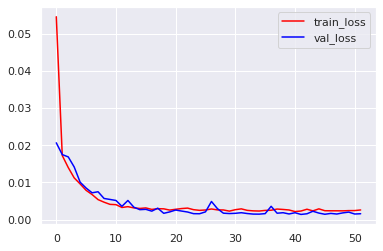

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.035736426402544826
************************************************************


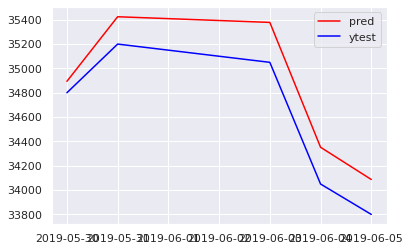

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.013615086117986919
************************************************************


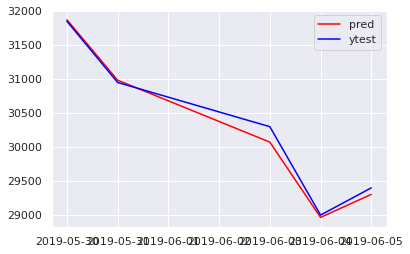

************************************************************
368 remain......
************************************************************
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 16)                1408      
                                                                 
 dense_32 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 16ms/step - loss: 0.0380 - val_loss: 0.0260
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0209
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.01

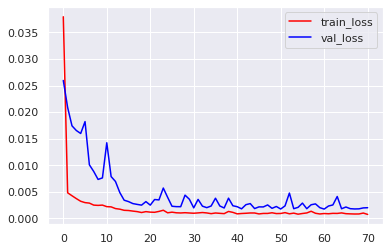

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.05721644369287365
************************************************************


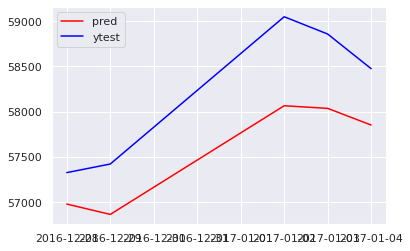

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.024968024056652556
************************************************************


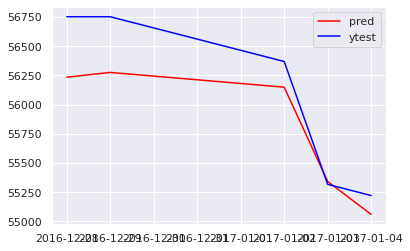

************************************************************
367 remain......
************************************************************
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 16)                1408      
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 16ms/step - loss: 0.0535 - val_loss: 0.1395
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 0.0124 - val_loss: 0.1342
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 0.0085 - val_loss: 0.09

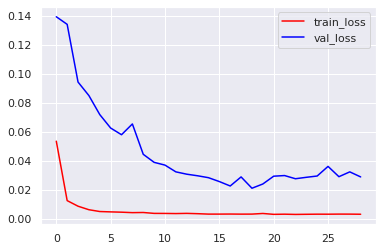

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.012636906808803302
************************************************************


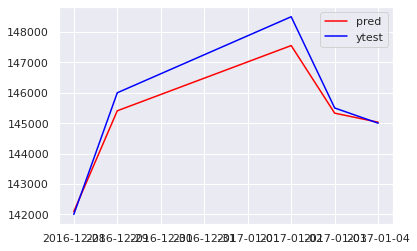

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.03288175411119858
************************************************************


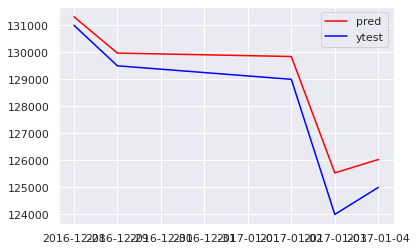

************************************************************
366 remain......
************************************************************
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 16)                1408      
                                                                 
 dense_34 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 16ms/step - loss: 0.0250 - val_loss: 0.0155
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 0.0115 - val_loss: 0.0139
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0096 - val_loss: 0.00

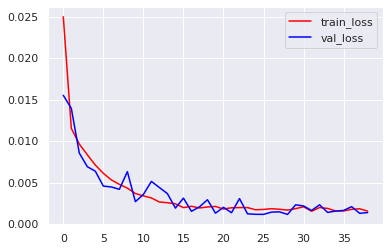

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.06044026321786691
************************************************************


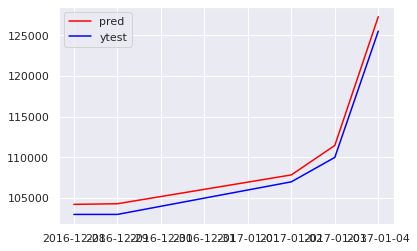

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.02827914402173913
************************************************************


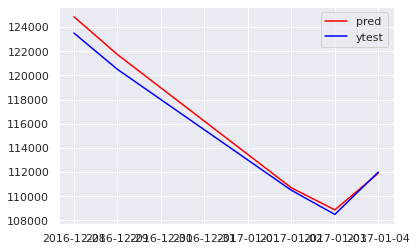

************************************************************
365 remain......
************************************************************
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 16)                1408      
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 16ms/step - loss: 0.0629 - val_loss: 0.0272
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0180 - val_loss: 0.0195
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0159 - val_loss: 0.01

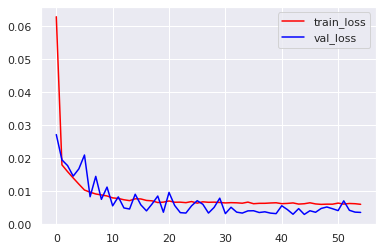

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.016518183479532163
************************************************************


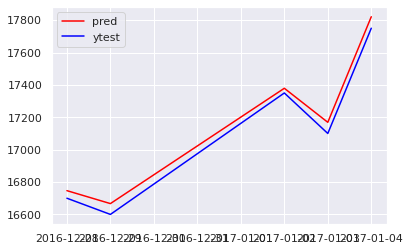

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.036080403857073444
************************************************************


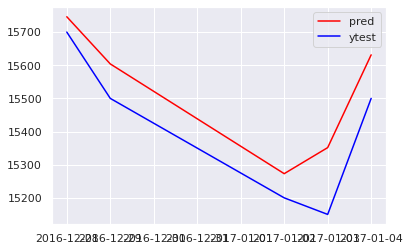

************************************************************
364 remain......
************************************************************
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 16)                1408      
                                                                 
 dense_36 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
104/104 [==============================] - 4s 18ms/step - loss: 0.0210 - val_loss: 0.0387
Epoch 2/100
104/104 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 3/100
104/104 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.00

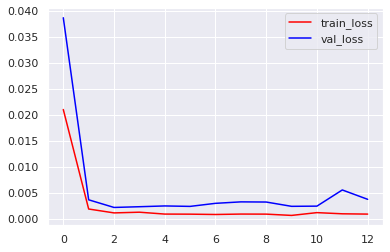

(5, 20, 5) (5, 1)
************************************************************
NMAE:  1.0153490364636124
************************************************************


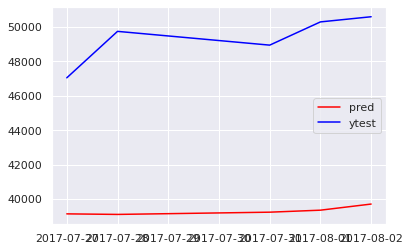

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.7931075730817827
************************************************************


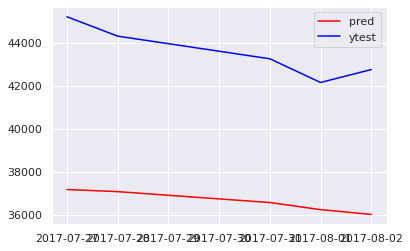

************************************************************
363 remain......
************************************************************
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 16)                1408      
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0487 - val_loss: 0.0235
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0068 - val_loss: 0.0188
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.01

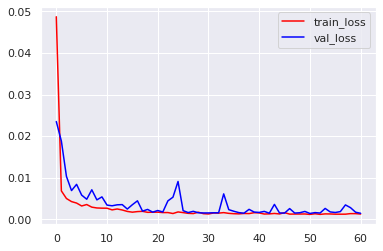

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.013962787347917642
************************************************************


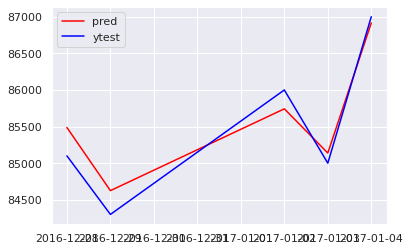

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.01624443077018943
************************************************************


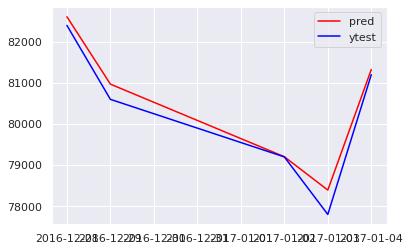

************************************************************
362 remain......
************************************************************
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 16)                1408      
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0395 - val_loss: 0.0042
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0026
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0065 - val_loss: 7.63

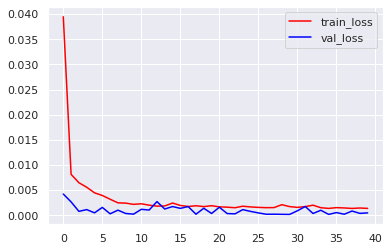

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.013605797658467223
************************************************************


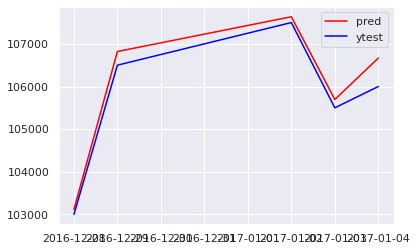

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.01779416522864551
************************************************************


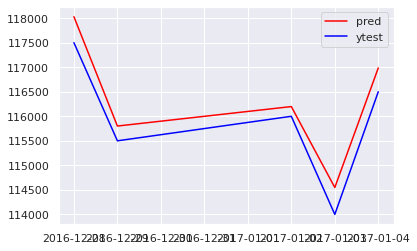

************************************************************
361 remain......
************************************************************
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 16)                1408      
                                                                 
 dense_39 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 18ms/step - loss: 0.0437 - val_loss: 0.0392
Epoch 2/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0088 - val_loss: 0.0291
Epoch 3/100
118/118 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 0.02

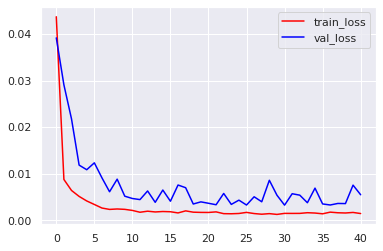

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.009300634057971014
************************************************************


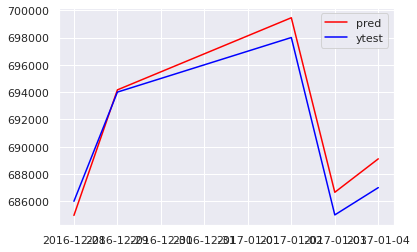

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.01620608372456964
************************************************************


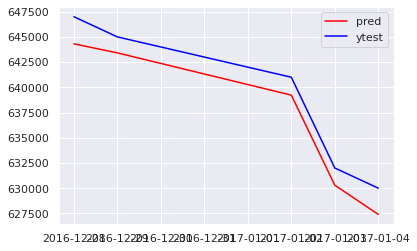

************************************************************
360 remain......
************************************************************
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 16)                1408      
                                                                 
 dense_40 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0163 - val_loss: 0.0035
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0012
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.00

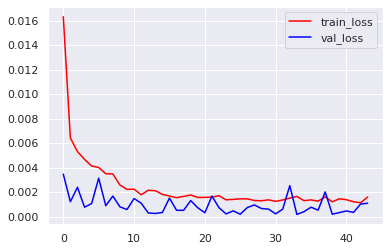

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.10424324785491405
************************************************************


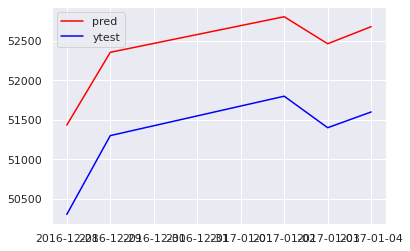

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.11379259814612869
************************************************************


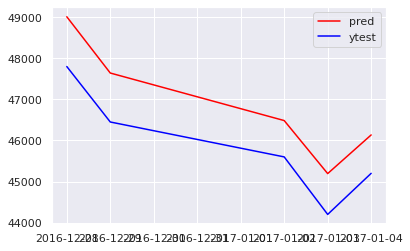

************************************************************
359 remain......
************************************************************
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 16)                1408      
                                                                 
 dense_41 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0766 - val_loss: 0.0617
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0162 - val_loss: 0.0287
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0138 - val_loss: 0.02

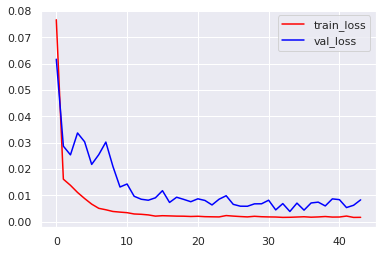

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.0042075365277184675
************************************************************


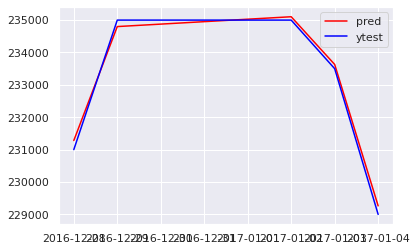

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.00971747819767442
************************************************************


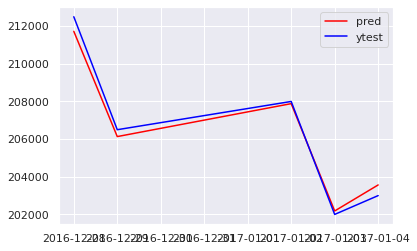

************************************************************
358 remain......
************************************************************
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 16)                1408      
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0350 - val_loss: 0.0070
Epoch 2/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0070 - val_loss: 0.0109
Epoch 3/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0067 - val_loss: 0.00

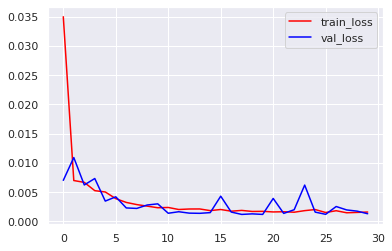

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.03847065298364914
************************************************************


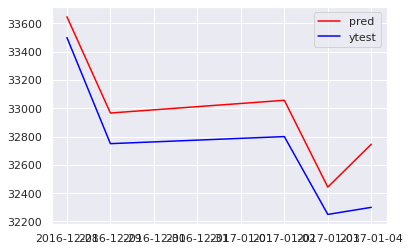

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.0195348995248067
************************************************************


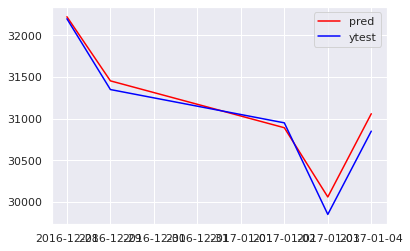

************************************************************
357 remain......
************************************************************
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 16)                1408      
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0138 - val_loss: 0.0030
Epoch 2/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.00

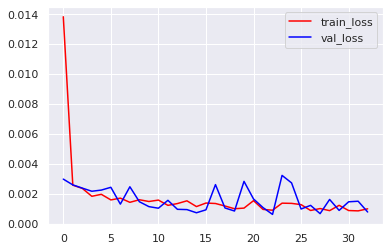

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.18516357589900206
************************************************************


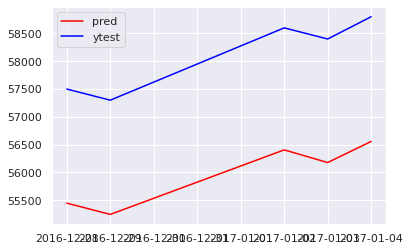

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.3779338103363355
************************************************************


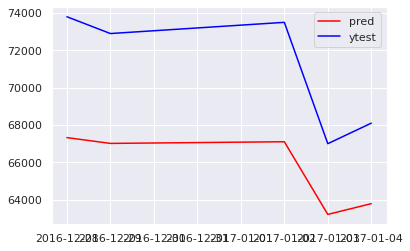

************************************************************
356 remain......
************************************************************
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 16)                1408      
                                                                 
 dense_44 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 5s 18ms/step - loss: 0.0372 - val_loss: 0.0058
Epoch 2/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0099 - val_loss: 0.0034
Epoch 3/100
118/118 [==============================] - 1s 13ms/step - loss: 0.0068 - val_loss: 0.00

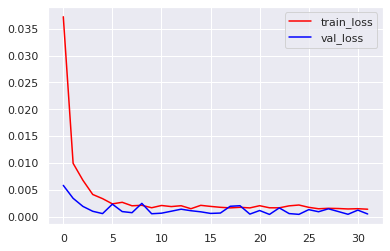

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.0364598607038121
************************************************************


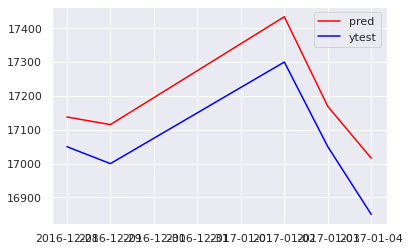

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.019038340182743294
************************************************************


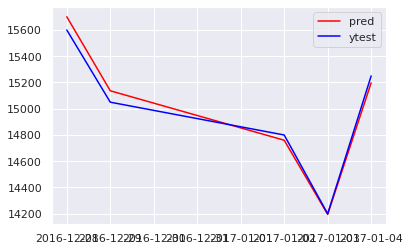

************************************************************
355 remain......
************************************************************
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 16)                1408      
                                                                 
 dense_45 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 0.0150 - val_loss: 0.0040
Epoch 2/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0046 - val_loss: 0.00

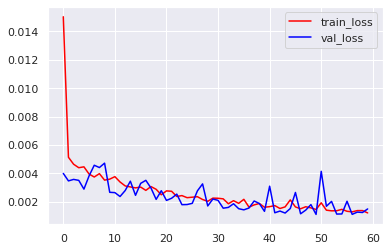

(5, 20, 5) (5, 1)
************************************************************
NMAE:  7.436899725997621
************************************************************


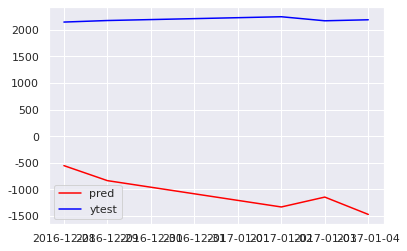

(5, 20, 5) (5, 1)
************************************************************
NMAE:  8.444933587301842
************************************************************


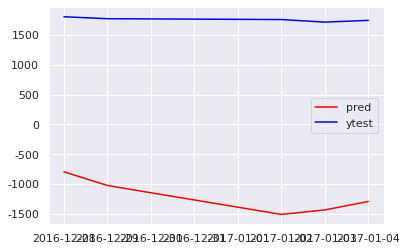

************************************************************
354 remain......
************************************************************
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 16)                1408      
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 5s 17ms/step - loss: 0.0216 - val_loss: 0.0157
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0126
Epoch 3/100
118/118 [==============================] - 2s 14ms/step - loss: 0.0070 - val_loss: 0.00

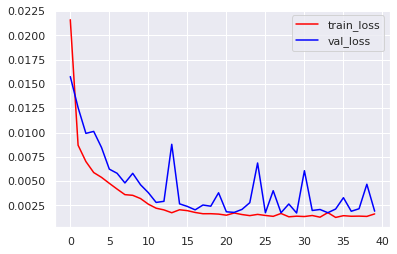

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.015099828041698262
************************************************************


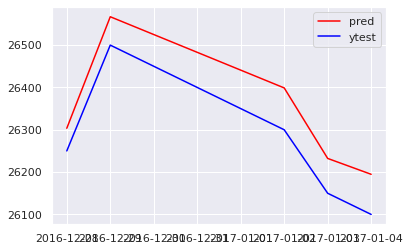

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.012438838267316467
************************************************************


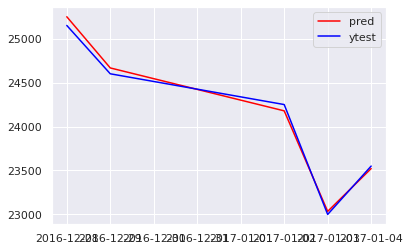

************************************************************
353 remain......
************************************************************
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 16)                1408      
                                                                 
 dense_47 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
118/118 [==============================] - 4s 18ms/step - loss: 0.0307 - val_loss: 0.0022
Epoch 2/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0106 - val_loss: 0.0048
Epoch 3/100
118/118 [==============================] - 2s 13ms/step - loss: 0.0077 - val_loss: 0.00

KeyboardInterrupt: ignored

In [ ]:
# # 한 기업 당 1분 30초 가량 걸리는 관계로 start_date 조정 위해 중단.
# # 1~17번째 기업까지는 기록 저장된 상태로 둠.

# i = 0
# # len(stock_list)

# for stock_code in stock_list[1:]:
#     i += 1
#     print('**'*30)
#     print(370-i,"remain......") # 370 == len(stock_list)-1
#     print('**'*30)

#     start_date = '19900101'
#     end_date = '20211215'

#     MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
#     WINDOW_SIZE__ = 20
#     UNITS__= 16
#     EPOCHS__ = 100
#     STOCK_CODE = stock_code

#     stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)

#     X, y = target_split(stock_q)

#     mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
#     mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

#     X_scaled = mms_X.fit_transform(X)
#     y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

#     X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
#     y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

#     X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
#     X_train, X_val, y_train, y_val = val_split(X_train, y_train)


#     mt = my_train(X_train, y_train)

#     mt.window_data()

#     mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

#     pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
#     pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

#     pred = np.zeros((10,1))
#     pred[:5] = pred1
#     pred[5:] = pred2

#     sub[STOCK_CODE] = pred


************************************************************
351 remain......
************************************************************
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 16)                1408      
                                                                 
 dense_48 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 40ms/step - loss: 0.2734 - val_loss: 0.1764
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0893 - val_loss: 0.0611
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0337 - val_loss: 0.0217
Epo

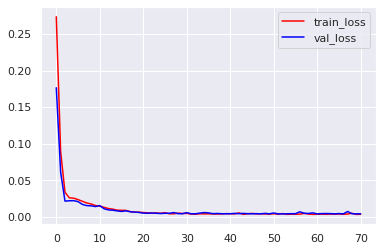

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.033165985460907335
************************************************************


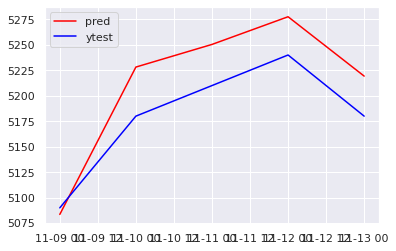

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.015460022679914616
************************************************************


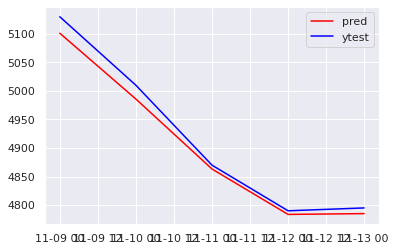

************************************************************
350 remain......
************************************************************
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 16)                1408      
                                                                 
 dense_49 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 36ms/step - loss: 0.5649 - val_loss: 0.0486
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 0.1325 - val_loss: 0.2389
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0783 - val_loss: 0.2150
Epo

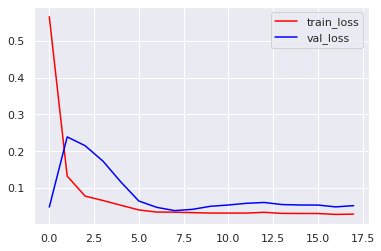

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.32903897126613396
************************************************************


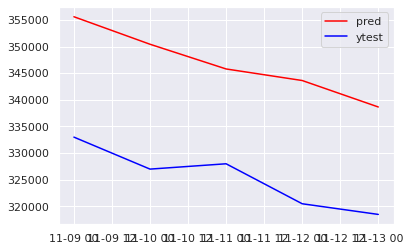

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.2359022978576367
************************************************************


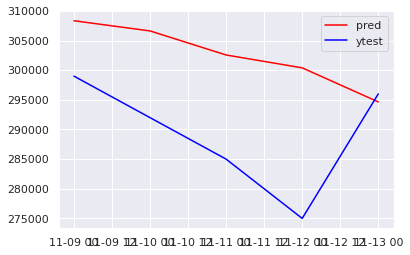

************************************************************
349 remain......
************************************************************
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 16)                1408      
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.2801 - val_loss: 0.1459
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0745 - val_loss: 0.0288
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0399 - val_loss: 0.0254
Epo

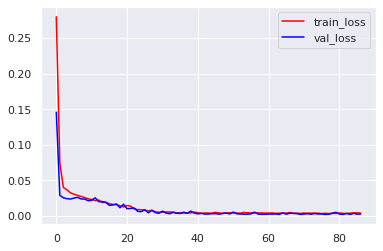

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.04353210667461264
************************************************************


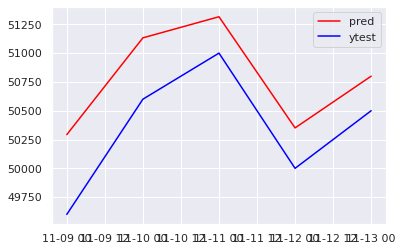

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.08791033253297847
************************************************************


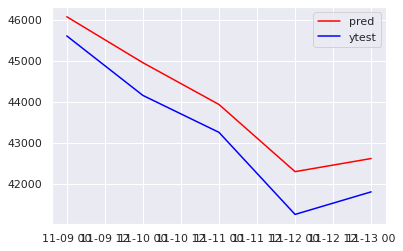

************************************************************
348 remain......
************************************************************
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 16)                1408      
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 38ms/step - loss: 0.0670 - val_loss: 0.2036
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0261 - val_loss: 0.0596
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0168 - val_loss: 0.0471
Epo

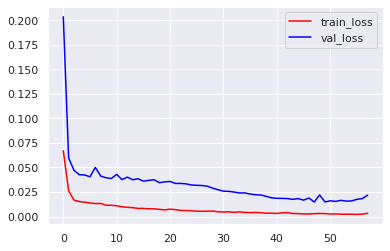

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.015484786794729298
************************************************************


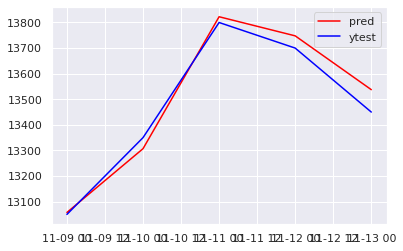

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.009974787785456731
************************************************************


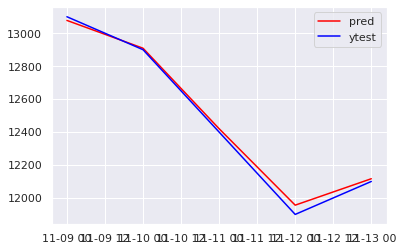

************************************************************
347 remain......
************************************************************
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 16)                1408      
                                                                 
 dense_52 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 36ms/step - loss: 0.0229 - val_loss: 0.0279
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0117 - val_loss: 0.0213
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0201
Epo

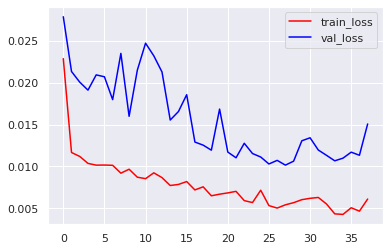

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.3742272157431609
************************************************************


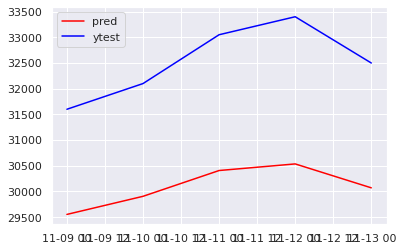

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.33754478422377443
************************************************************


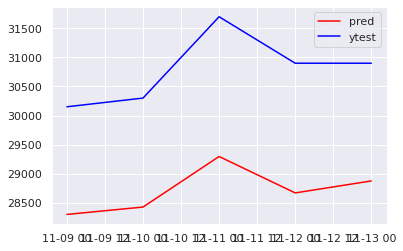

************************************************************
346 remain......
************************************************************
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 16)                1408      
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
21/21 [==============================] - 3s 41ms/step - loss: 0.0704 - val_loss: 0.0106
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0291 - val_loss: 0.0223
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0208 - val_loss: 0.0108
Epo

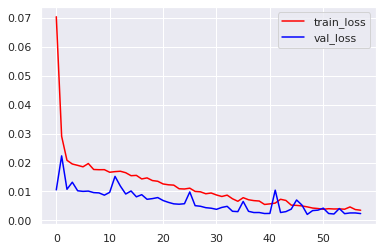

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.009587262656116567
************************************************************


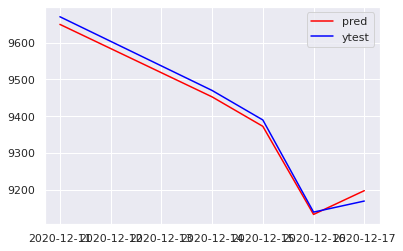

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.08356193757963475
************************************************************


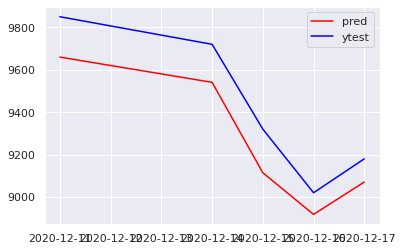

************************************************************
345 remain......
************************************************************
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 16)                1408      
                                                                 
 dense_54 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.3405 - val_loss: 0.0435
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1377 - val_loss: 0.0379
Epoch 3/100
24/24 [==============================] - 0s 12ms/step - loss: 0.1034 - val_loss: 0.0470
Epo

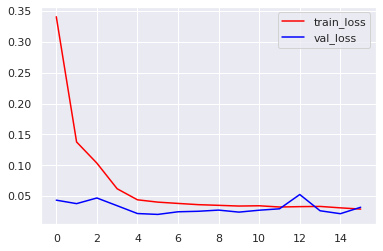

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.2556811407383663
************************************************************


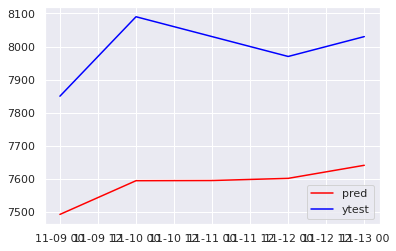

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.13199385436467642
************************************************************


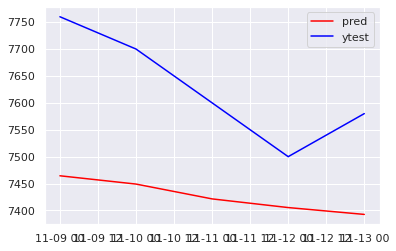

************************************************************
344 remain......
************************************************************
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 16)                1408      
                                                                 
 dense_55 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.6087 - val_loss: 0.1794
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1336 - val_loss: 0.1089
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0431 - val_loss: 0.0825
Epo

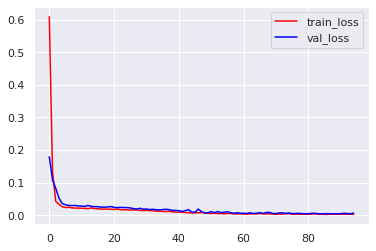

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.05357324347076216
************************************************************


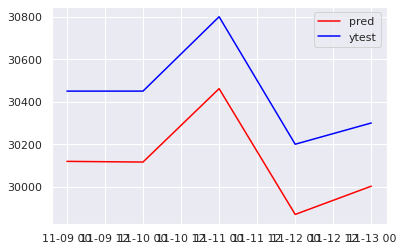

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.04421174578884375
************************************************************


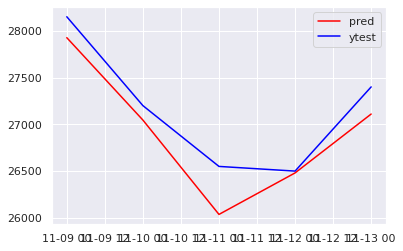

************************************************************
343 remain......
************************************************************
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 16)                1408      
                                                                 
 dense_56 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 58ms/step - loss: 0.1127 - val_loss: 0.0514
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0370 - val_loss: 0.0377
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0144 - val_loss: 0.0200
Epo

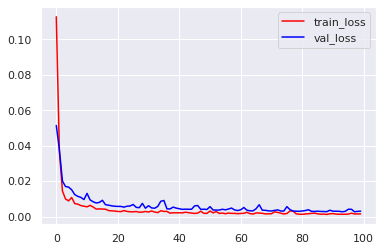

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.22373438576843557
************************************************************


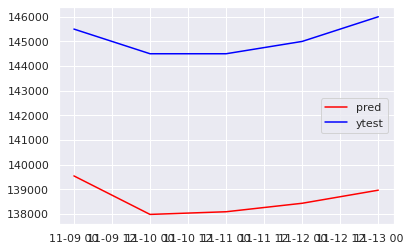

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.3419322752365931
************************************************************


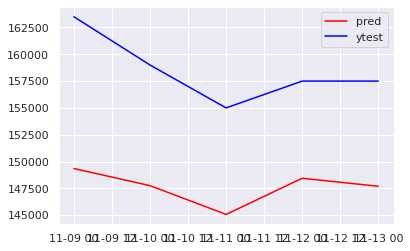

************************************************************
342 remain......
************************************************************
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 16)                1408      
                                                                 
 dense_57 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.0616 - val_loss: 0.0803
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0457 - val_loss: 0.0775
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0291 - val_loss: 0.0308
Epo

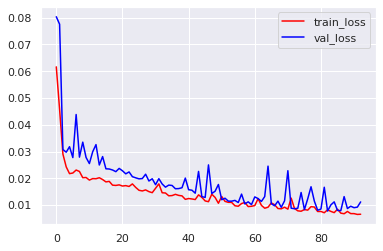

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.10304582258998106
************************************************************


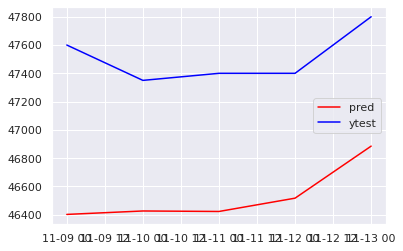

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.06841906685487746
************************************************************


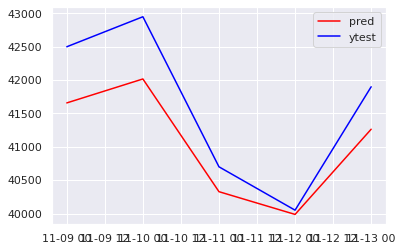

************************************************************
341 remain......
************************************************************
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 16)                1408      
                                                                 
 dense_58 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 38ms/step - loss: 0.0832 - val_loss: 0.0268
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0250 - val_loss: 0.0214
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0179 - val_loss: 0.0185
Epo

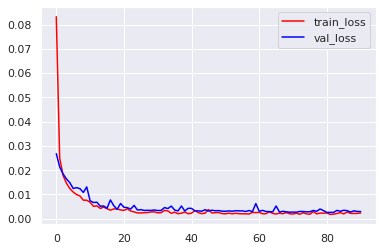

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.07073686161331184
************************************************************


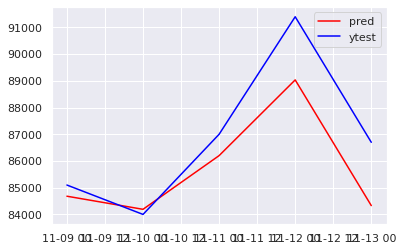

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.029684429671653512
************************************************************


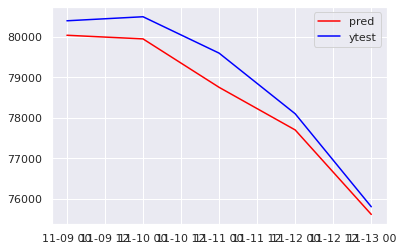

************************************************************
340 remain......
************************************************************
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 16)                1408      
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 39ms/step - loss: 0.2556 - val_loss: 0.2795
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0825 - val_loss: 0.1494
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0489 - val_loss: 0.0529
Epo

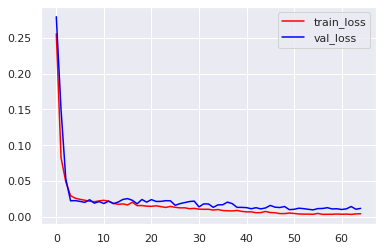

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.0130085948167953
************************************************************


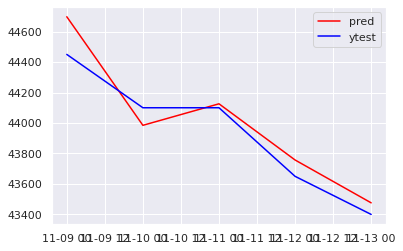

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.015121972934472934
************************************************************


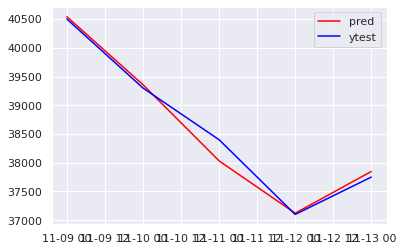

************************************************************
339 remain......
************************************************************
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 16)                1408      
                                                                 
 dense_60 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 39ms/step - loss: 0.1810 - val_loss: 0.1180
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0614 - val_loss: 0.0351
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0389 - val_loss: 0.0274
Epo

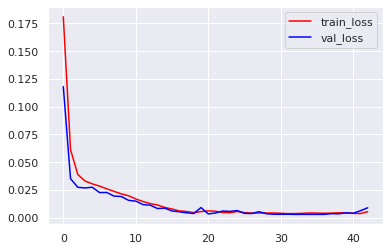

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.04924949091478684
************************************************************


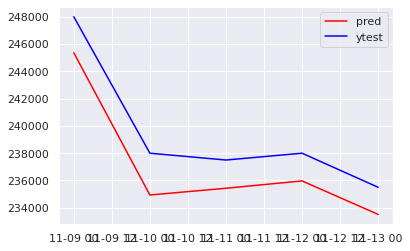

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.1021513822661217
************************************************************


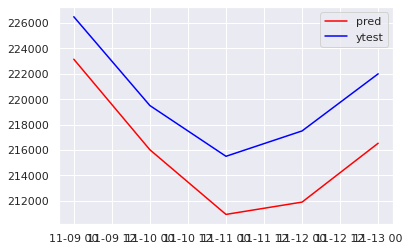

************************************************************
338 remain......
************************************************************
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 16)                1408      
                                                                 
 dense_61 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 39ms/step - loss: 0.1757 - val_loss: 0.1004
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0584 - val_loss: 0.0749
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0429 - val_loss: 0.0657
Epo

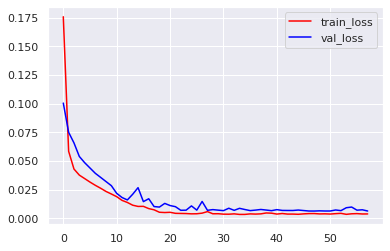

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.003145737733851041
************************************************************


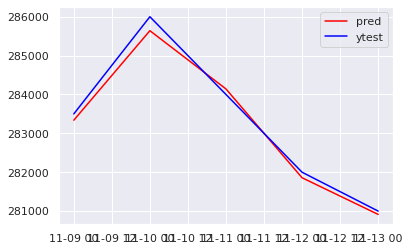

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.023884622175141243
************************************************************


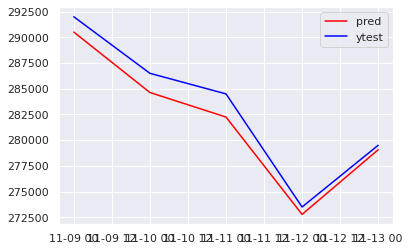

************************************************************
337 remain......
************************************************************
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 16)                1408      
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 36ms/step - loss: 0.1616 - val_loss: 0.1227
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0384 - val_loss: 0.0652
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0276 - val_loss: 0.0662
Epo

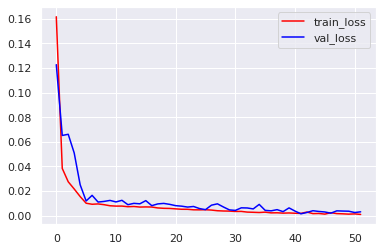

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.18528255466427138
************************************************************


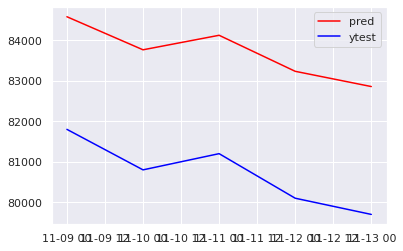

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.19397582219855392
************************************************************


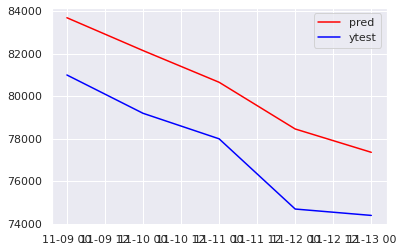

************************************************************
336 remain......
************************************************************
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 16)                1408      
                                                                 
 dense_63 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 38ms/step - loss: 0.2495 - val_loss: 0.1249
Epoch 2/100
24/24 [==============================] - 0s 17ms/step - loss: 0.1110 - val_loss: 0.0652
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0945 - val_loss: 0.0606
Epo

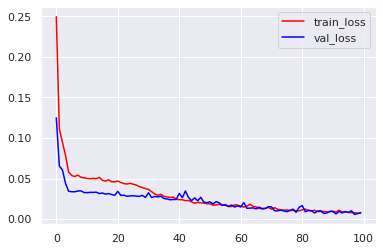

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.12532311338244004
************************************************************


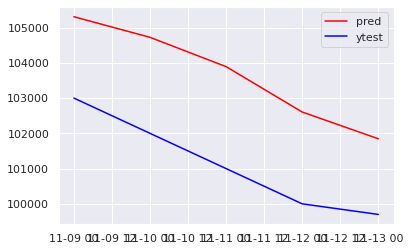

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.06354294131730155
************************************************************


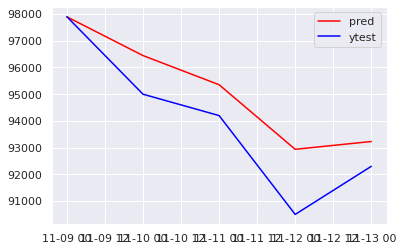

************************************************************
335 remain......
************************************************************
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 16)                1408      
                                                                 
 dense_64 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.2110 - val_loss: 0.3060
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1307 - val_loss: 0.2018
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0842 - val_loss: 0.1098
Epo

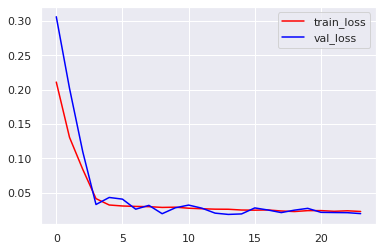

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.04443344716301411
************************************************************


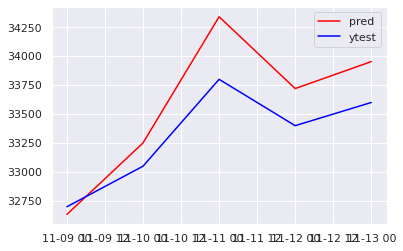

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.039567380229001324
************************************************************


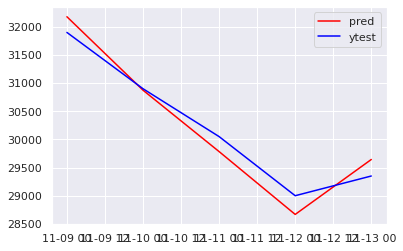

************************************************************
334 remain......
************************************************************
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 16)                1408      
                                                                 
 dense_65 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.1348 - val_loss: 0.0397
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0306 - val_loss: 0.0302
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0220 - val_loss: 0.0309
Epo

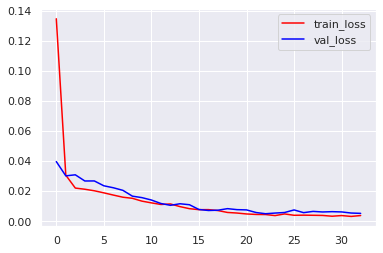

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.041743859723160026
************************************************************


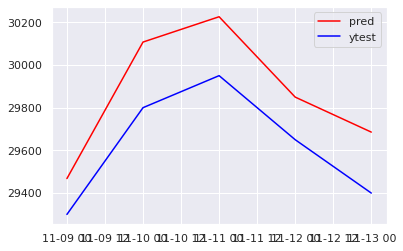

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.00372834760607226
************************************************************


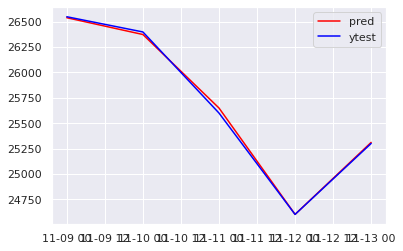

************************************************************
333 remain......
************************************************************
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 16)                1408      
                                                                 
 dense_66 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 6s 79ms/step - loss: 0.1242 - val_loss: 0.1048
Epoch 2/100
24/24 [==============================] - 1s 26ms/step - loss: 0.0321 - val_loss: 0.0799
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0218 - val_loss: 0.0829
Epo

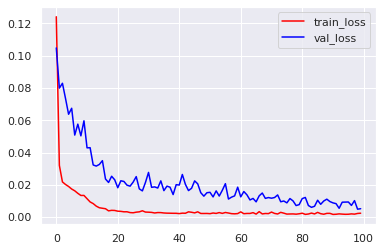

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.041885125184094256
************************************************************


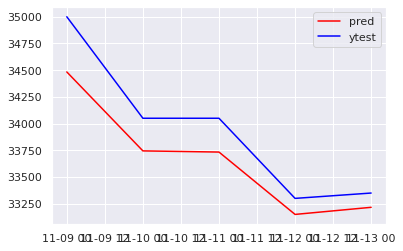

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.060093918583191366
************************************************************


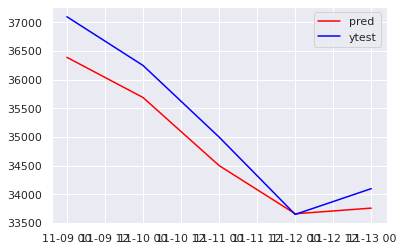

************************************************************
332 remain......
************************************************************
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 16)                1408      
                                                                 
 dense_67 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 40ms/step - loss: 0.4986 - val_loss: 0.2481
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1155 - val_loss: 0.3060
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0997 - val_loss: 0.3485
Epo

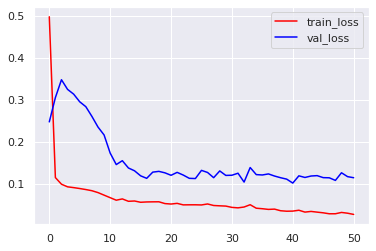

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.10823113207547169
************************************************************


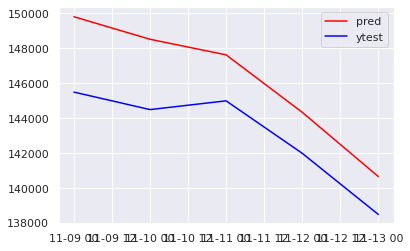

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.029504171275811102
************************************************************


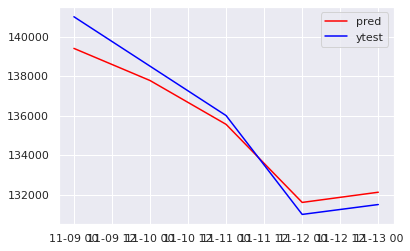

************************************************************
331 remain......
************************************************************
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 16)                1408      
                                                                 
 dense_68 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 40ms/step - loss: 0.0947 - val_loss: 0.0558
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0256 - val_loss: 0.0439
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0403
Epo

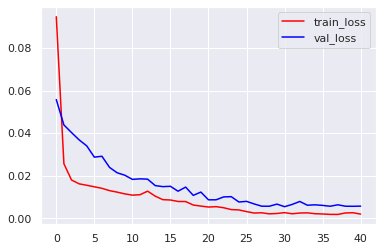

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.07045101633285687
************************************************************


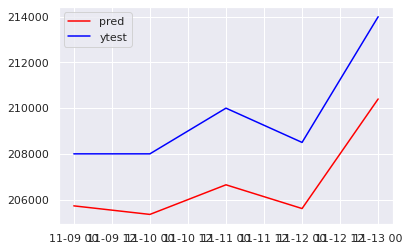

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.04812584876543238
************************************************************


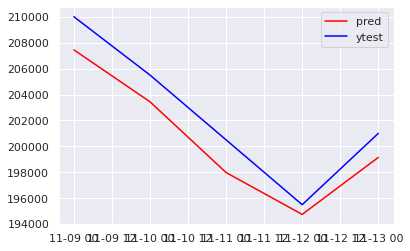

************************************************************
330 remain......
************************************************************
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 16)                1408      
                                                                 
 dense_69 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 61ms/step - loss: 0.2312 - val_loss: 0.1498
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0800 - val_loss: 0.0522
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0455 - val_loss: 0.0358
Epo

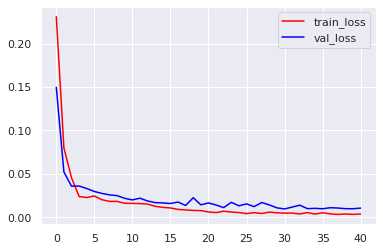

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.029641656869760932
************************************************************


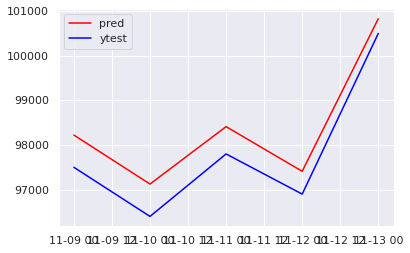

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.031125059891396932
************************************************************


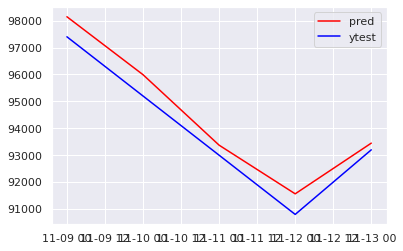

************************************************************
329 remain......
************************************************************
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 16)                1408      
                                                                 
 dense_70 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 39ms/step - loss: 0.1526 - val_loss: 0.1083
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0563
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0250 - val_loss: 0.0320
Epo

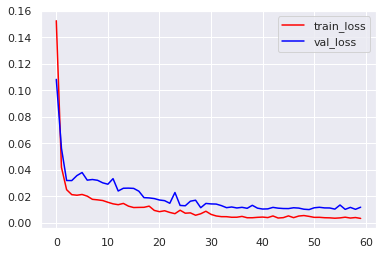

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.01939012505062764
************************************************************


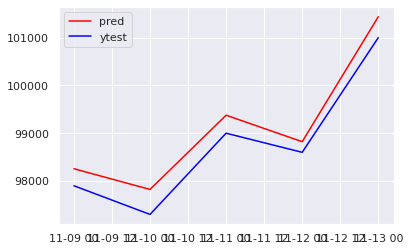

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.02869367884374347
************************************************************


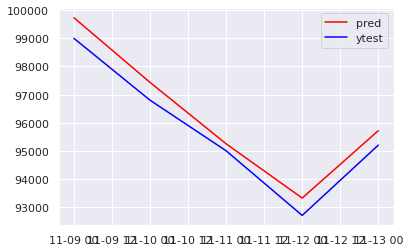

************************************************************
328 remain......
************************************************************
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 16)                1408      
                                                                 
 dense_71 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 38ms/step - loss: 0.4954 - val_loss: 0.0376
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.1208 - val_loss: 0.1661
Epoch 3/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0665 - val_loss: 0.0699
Epo

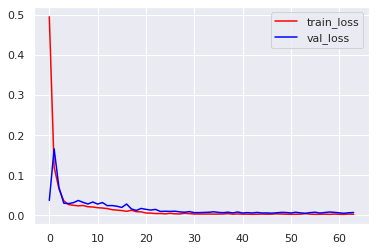

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.01760276704736292
************************************************************


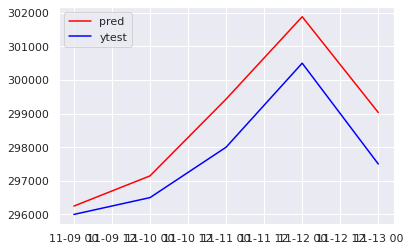

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.006621404458009619
************************************************************


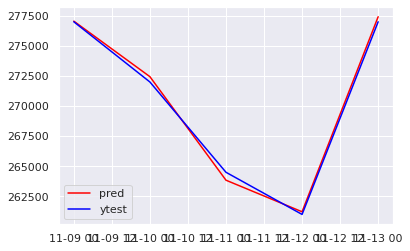

************************************************************
327 remain......
************************************************************
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 16)                1408      
                                                                 
 dense_72 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 5s 66ms/step - loss: 0.6362 - val_loss: 0.0777
Epoch 2/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0912 - val_loss: 0.0689
Epoch 3/100
24/24 [==============================] - 1s 28ms/step - loss: 0.0473 - val_loss: 0.0618
Epo

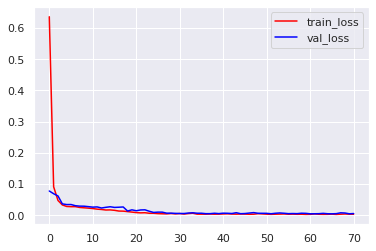

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.011100216604979934
************************************************************


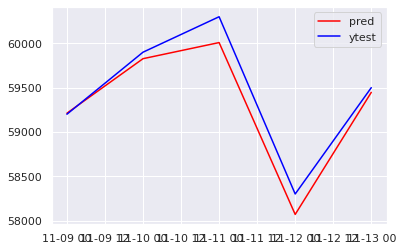

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.005691747432457708
************************************************************


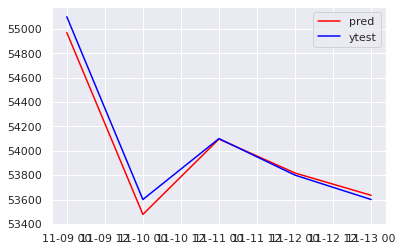

************************************************************
326 remain......
************************************************************
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 16)                1408      
                                                                 
 dense_73 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 89ms/step - loss: 0.2060 - val_loss: 0.1699
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0470 - val_loss: 0.1138
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0398 - val_loss: 0.0973
Epo

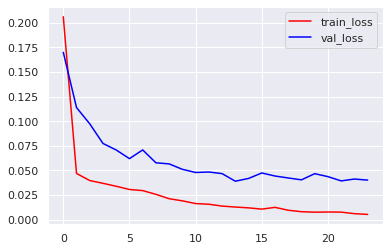

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.08844141327984403
************************************************************


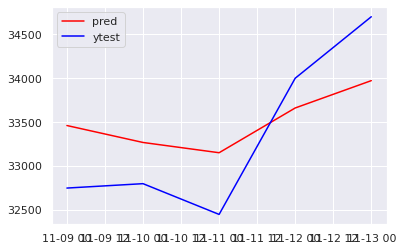

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.13169003423481854
************************************************************


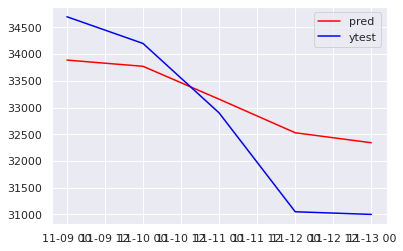

************************************************************
325 remain......
************************************************************
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 16)                1408      
                                                                 
 dense_74 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 4s 41ms/step - loss: 0.0661 - val_loss: 0.0838
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0576 - val_loss: 0.0897
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0511 - val_loss: 0.0930
Epo

KeyboardInterrupt: ignored

In [ ]:
# # 속도 개선 위해 44번째에서 중단 후 코드 수정

# i = 18
# # len(stock_list)

# for stock_code in stock_list[18:]:
#     i += 1
#     print('**'*30)
#     print(370-i,"remain......") # 370 == len(stock_list)-1
#     print('**'*30)

#     start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
#     end_date = '20211215'

#     MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
#     WINDOW_SIZE__ = 20
#     UNITS__= 16
#     EPOCHS__ = 100
#     STOCK_CODE = stock_code

#     stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)

#     X, y = target_split(stock_q)

#     mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
#     mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

#     X_scaled = mms_X.fit_transform(X)
#     y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

#     X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
#     y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

#     X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
#     X_train, X_val, y_train, y_val = val_split(X_train, y_train)


#     mt = my_train(X_train, y_train)

#     mt.window_data()

#     mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

#     pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
#     pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

#     pred = np.zeros((10,1))
#     pred[:5] = pred1
#     pred[5:] = pred2

#     sub[STOCK_CODE] = pred


************************************************************
325 remain......
************************************************************
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 16)                1408      
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.0704 - val_loss: 0.1265
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0540 - val_loss: 0.0991
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0496 - val_loss: 0.0835
Epo

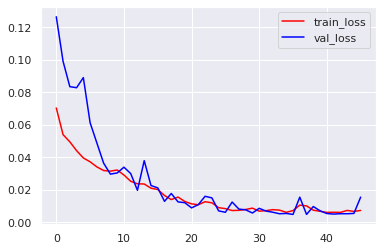

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.06794124432140829
************************************************************


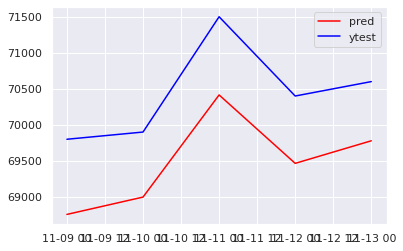

(5, 20, 5) (5, 1)
************************************************************
NMAE:  0.07357089199862638
************************************************************


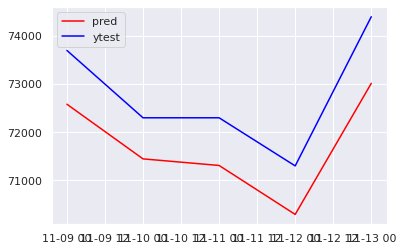

************************************************************
324 remain......
************************************************************


In [ ]:
# i = 44
# # len(stock_list)

# start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
# end_date = '20211215'
# # MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
# WINDOW_SIZE__ = 20
# UNITS__= 16
# EPOCHS__ = 100
# STOCK_CODE = stock_code

# for stock_code in stock_list[44:]:
#     i += 1
#     print('**'*30)
#     print(370-i,"remain......") # 370 == len(stock_list)-1
#     print('**'*30)
   

#     stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)

#     X, y = target_split(stock_q)

#     mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
#     mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

#     X_scaled = mms_X.fit_transform(X)
#     y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

#     X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
#     y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

#     X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
#     X_train, X_val, y_train, y_val = val_split(X_train, y_train)


#     mt = my_train(X_train, y_train)

#     mt.window_data()

#     mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

#     pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
#     pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

#     pred = np.zeros((10,1))
#     pred[:5] = pred1
#     pred[5:] = pred2

#     sub[STOCK_CODE] = pred


# 5. Feature Engineering

* 1) 많은 데이터에서 하락기에 있는 데이터는 과대예측, 상승기에 있는 과소예측하는 경향 존재.(거의 유사한 경우도 많다.)
-> 과거보다 커진 변동성을 반영하고 있지 못하다.
-> 단기 이동평균선 도입 필요

* 2) 변동성 지수 도입

## 5.1 Moving Average

### 네이버 주식에서 MovingAverage 변수 도입 시 성능 변화(5,20,50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1472      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 33ms/step - loss: 0.0341 - val_loss: 0.1910
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.1619
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0195 - val_loss: 0.1274
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0183 - val_loss: 0.1167
Epoch 5/100
24/24 [========================

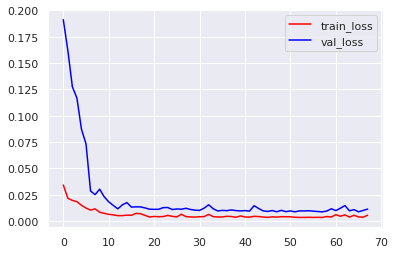

(5, 20, 6) (5, 1)
************************************************************
NMAE:  2.585333031993136
************************************************************


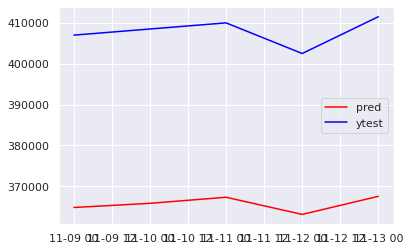

(5, 20, 6) (5, 1)
************************************************************
NMAE:  2.2432323816872435
************************************************************


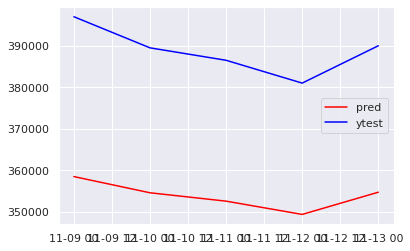

In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
24/24 [==============================] - 3s 42ms/step - loss: 0.0244 - val_loss: 0.1150
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0904
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.0430
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0164 - val_loss: 0.0519
Epoch 5/100
24/24 [==========================

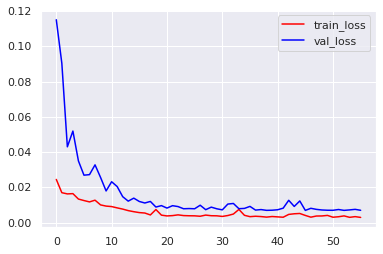

(5, 20, 6) (5, 1)
************************************************************
NMAE:  1.5837429517038495
************************************************************


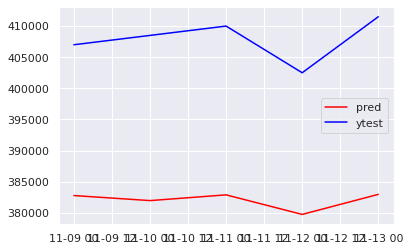

(5, 20, 6) (5, 1)
************************************************************
NMAE:  1.2197888535236634
************************************************************


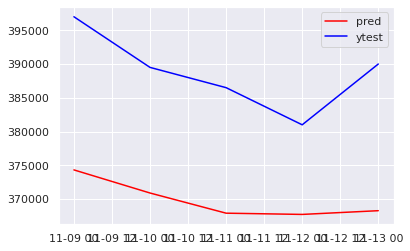

In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


# -----------------------------moving average ---------------------------
stock_q = fdr.DataReader(STOCK_CODE, start = start_date, end = end_date)
stock_q = stock_q.fillna(method = 'bfill')
stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
# stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
# stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
stock_q = stock_q.dropna()
# -----------------------------------------------------------------------

X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16)                1536      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 34ms/step - loss: 0.0592 - val_loss: 0.2771
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0415 - val_loss: 0.2200
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0300 - val_loss: 0.1431
Epoch 4/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0202 - val_loss: 0.0875
Epoch 5/100
23/23 [========================

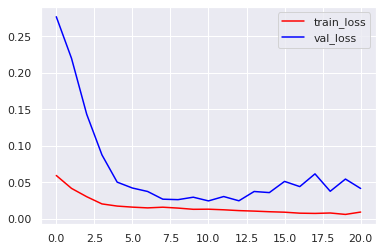

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.2858865530767338
************************************************************


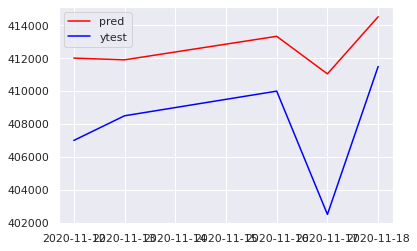

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.6600806970164601
************************************************************


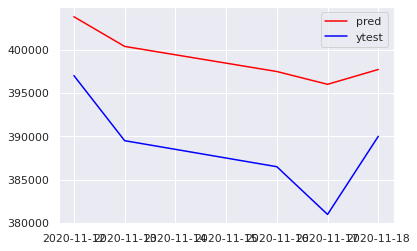

In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


# -----------------------------moving average ---------------------------
stock_q = fdr.DataReader(STOCK_CODE, start = start_date, end = end_date)
stock_q = stock_q.fillna(method = 'bfill')
stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
# stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
stock_q = stock_q.dropna()
# -----------------------------------------------------------------------

X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1600      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 35ms/step - loss: 0.0637 - val_loss: 0.3649
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0379 - val_loss: 0.2376
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0274 - val_loss: 0.1520
Epoch 4/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0243 - val_loss: 0.1315
Epoch 5/100
23/23 [========================

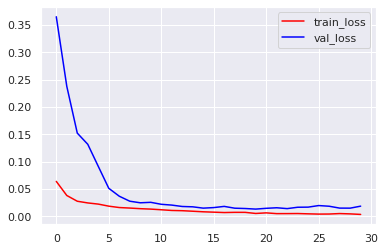

(5, 20, 8) (5, 1)
************************************************************
NMAE:  3.5187408065702384
************************************************************


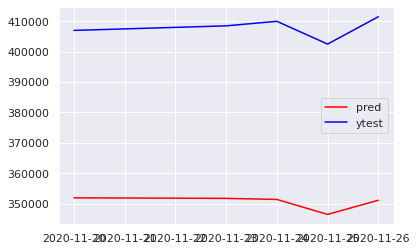

(5, 20, 8) (5, 1)
************************************************************
NMAE:  3.467459169238684
************************************************************


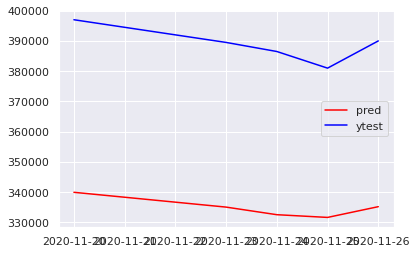

In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


# -----------------------------moving average ---------------------------
stock_q = fdr.DataReader(STOCK_CODE, start = start_date, end = end_date)
stock_q = stock_q.fillna(method = 'bfill')
stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
stock_q = stock_q.dropna()
# -----------------------------------------------------------------------

X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


### 결론: ma 5와 ma 20을 도입했을 때 가장 성능이 좋음.(하나의 기업을 가지고만 판별했기 때문에 검증 필요)

# 전체 데이터에 대해 모델 돌리기
<방법>
1. 모든 개별 회사에 대해 fit
2. 산업별 대표격 되는 회사에 대해 fit 하고 weight 사용해서 나머지 빨리 돌림(근데 금방 돌아가는데 모델이 안 딥해서)ㅡ

In [ ]:
############################################################

In [ ]:
start_date='2000-01-01'
end_date='2021-12-15'

# plt.plot(vix[(start_date <= vix.index) & (vix.index <= end_date)]['Close'], label='Close')
plt.plot(vix[(start_date <= vix.index) & (vix.index <= end_date)]['Change']*100, label='Change*100')
# plt.plot(stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)]['Close'], label='Close_p')
plt.plot(stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)]['Change']*100, label='p_Change*100')
# plt.plot(stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)]['Close'], label='Close_q')
plt.plot(stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)]['Change']*100, label='q_Change*100')


plt.legend()
plt.show()

In [ ]:
temp1 = vix[(start_date <= vix.index) & (vix.index <= end_date)][['Change', 'Close']]
temp2 = stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)][['Change', 'Close']]
temp3 = stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)][['Change', 'Close']]

temp = pd.concat([temp1, temp2, temp3], axis=1)

In [ ]:
temp.columns=['Change_vix', 'Close_vix', 'Change_p', 'Close_p', 'Change_q', 'Close_q']

In [ ]:
temp_list = [col for col in temp.columns if 'Close' in col]
sns.heatmap(temp[temp_list].corr(), annot=True, fmt=".2f", center=0, cmap='YlGnBu')

In [ ]:
temp_list = [col for col in temp.columns if 'Change' in col]
sns.heatmap(temp[temp_list].corr(), annot=True, fmt=".2f", center=0, cmap='YlGnBu')

In [ ]:
sns.heatmap(abs(temp.corr()), annot=True, fmt=".2f", center=0, cmap='YlGnBu')